In [1]:
from QuantLib import *
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tf_quant_finance as tff 
import tensorflow as tf
from scipy.interpolate import interp1d

# Shortcut alias
pde = tff.math.pde
option_price = tff.black_scholes.option_price
implied_vol = tff.black_scholes.implied_vol

In [2]:
tqf_BS_price = option_price(
      volatilities=tf.constant(0.20,tf.float64),
      strikes=tf.constant(40.0,tf.float64),
      expiries=tff.datetime.daycount_actual_actual_isda(
          start_date=tff.datetime.dates_from_tuples([(1998, 5, 15)]), 
          end_date=tff.datetime.dates_from_tuples([(1999, 5, 15)]),
          dtype=tf.float64),
      spots=tf.constant(36.0,tf.float64),
      discount_rates=tf.constant(0.02,tf.float64),
      dividend_rates=tf.constant(0.07,tf.float64),
      #is_call_options=is_call_options
      ).numpy()[0]
print(tqf_BS_price)

0.9057414542975113


In [3]:
def ql_european_price(calc_date, settlement_date, expiry_date, spot, strike, rf, div, vol):
    Settings.instance().evaluationDate = calc_date
    riskFreeRate = FlatForward(settlement_date, rf, Actual365Fixed())
    exercise = EuropeanExercise(expiry_date)
    payoff = PlainVanillaPayoff(Option.Call, strike)
    underlying = SimpleQuote(spot)
    volatility = BlackConstantVol(calc_date, TARGET(), vol, Actual365Fixed())
    dividendYield = FlatForward(settlement_date, div, Actual365Fixed())
    process = BlackScholesMertonProcess(QuoteHandle(underlying),
                                        YieldTermStructureHandle(dividendYield),
                                        YieldTermStructureHandle(riskFreeRate),
                                        BlackVolTermStructureHandle(volatility))
    option = VanillaOption(payoff, exercise)
    option.setPricingEngine(AnalyticEuropeanEngine(process))
    closedFormulaNPV = option.NPV()
    return closedFormulaNPV

ql_price = ql_european_price(
    calc_date=Date(15,May,1998),
    settlement_date=Date(15,May,1998),
    expiry_date=Date(15,May,1999),
    spot=36.0,
    strike=40.0,
    rf=0.02,
    div=0.07,
    vol=0.20
)
print('Black Scholes', ql_price)

Black Scholes 0.9057414542975114


In [4]:
# tf.function decorator makes the function faster in graph mode.
@tf.function
def american_option(number_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    dividend_rates,
                    expiry,
                    spot,
                    european_exercise=False,
                    nb_bound=3.0,
                    dtype=tf.float64):
  """ Computes American Call options prices.

  Args:
    number_grid_points: A Python int. Number of grid points for the finite
      difference scheme.
    time_delta: A Python float. Grid time discretization parameter.
    strike: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the strikes of the underlying American options. 
    volatility: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the volatilities of the underlying American options. 
    risk_free_rate: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the risk-free interest rates associated with the underlying
      American options.
    expiry: A Python float. Expiry date of the options. If the options
      have different expiries, volatility term has to adjusted to
      make expiries the same.
    dtype: Optional `tf.dtype` used to assert dtype of the input `Tensor`s.

  Returns:
    A tuple of the estimated option prices of shape
    `(number_of_options, number_grid_points)` and the corresponding `Tensor` 
    of grid locations of shape `(number_grid_points,)`.
  """
  # Define the coordinate grid
  s_min = spot/nb_bound #0.01
  s_max = nb_bound*spot #300.
  grid = pde.grids.uniform_grid(minimums=[s_min],
                                maximums=[s_max],
                                sizes=[number_grid_points],
                                dtype=dtype)

  # Define the values grid for the final condition
  s = grid[0]
  final_values_grid = tf.nn.relu(s - strike)

  # Define the PDE coefficient functions
  def second_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [[volatility ** 2 * s ** 2 / 2]]

  def first_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [(risk_free_rate-dividend_rates) * s]

  def zeroth_order_coeff_fn(t, grid):
    del t, grid
    return -risk_free_rate

  # Define the boundary conditions
  @pde.boundary_conditions.dirichlet
  def lower_boundary_fn(t, grid):
    del t, grid
    return tf.constant(0.0, dtype=dtype)

  @pde.boundary_conditions.dirichlet
  def upper_boundary_fn(t, grid):
    del grid
    return tf.squeeze(s_max - strike * tf.exp(-(risk_free_rate-dividend_rates) * (expiry - t)))

  # In order to price American option one needs to set option values to 
  # V(x) := max(V(x), max(x - strike, 0)) after each iteration
  def values_transform_fn(t, grid, values):
    del t
    s = grid[0]
    if european_exercise==False:
        values_floor = tf.nn.relu(s - strike)
        return grid, tf.maximum(values, values_floor)
    else:
        return grid, values

  # Solve
  estimate_values, estimate_grid, _, _ = \
    pde.fd_solvers.solve_backward(
      start_time=expiry,
      end_time=0,
      values_transform_fn=values_transform_fn,
      coord_grid=grid,
      values_grid=final_values_grid,
      time_step=time_delta,
      boundary_conditions=[(lower_boundary_fn, upper_boundary_fn)],
      second_order_coeff_fn=second_order_coeff_fn,
      first_order_coeff_fn=first_order_coeff_fn,
      zeroth_order_coeff_fn=zeroth_order_coeff_fn,
      dtype=dtype
    )
  return estimate_values, estimate_grid[0]

def tqf_price(number_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    dividend_rates,
                    expiry,
                    spot,
                    european_exercise=False,
                    nb_bound=3.0,
                    dtype=tf.float64):
    estimate, grid_locations = american_option(
    time_delta=time_delta,
    expiry=tff.datetime.daycount_actual_actual_isda(
          start_date=tff.datetime.dates_from_tuples([(1998, 5, 15)]), 
          end_date=tff.datetime.dates_from_tuples([(1999, 5, 15)]),
          dtype=tf.float64).numpy()[0],
    number_grid_points=number_grid_points,
    volatility=tf.constant(0.20,tf.float64),
    risk_free_rate=tf.constant(0.02,tf.float64),
    dividend_rates=tf.constant(0.07,tf.float64),
    strike=tf.constant(40.0,tf.float64),
    spot=36.0,
    european_exercise=True,
    nb_bound=3.0,
    dtype=tf.float64)

    # Convert to numpy for plotting
    estimate = estimate.numpy()
    grid_locations = grid_locations.numpy()
    tqf_euro_price_pde = interp1d(grid_locations, estimate)(36.0)
    return tqf_euro_price_pde

[0.00000000e+00 5.97381838e-11 1.23970870e-10 ... 6.56989573e+01
 6.58239356e+01 6.59491561e+01]
[ 12.          12.09384164  12.18768328 ... 107.81231672 107.90615836
 108.        ]
premium 0.9057680677666174


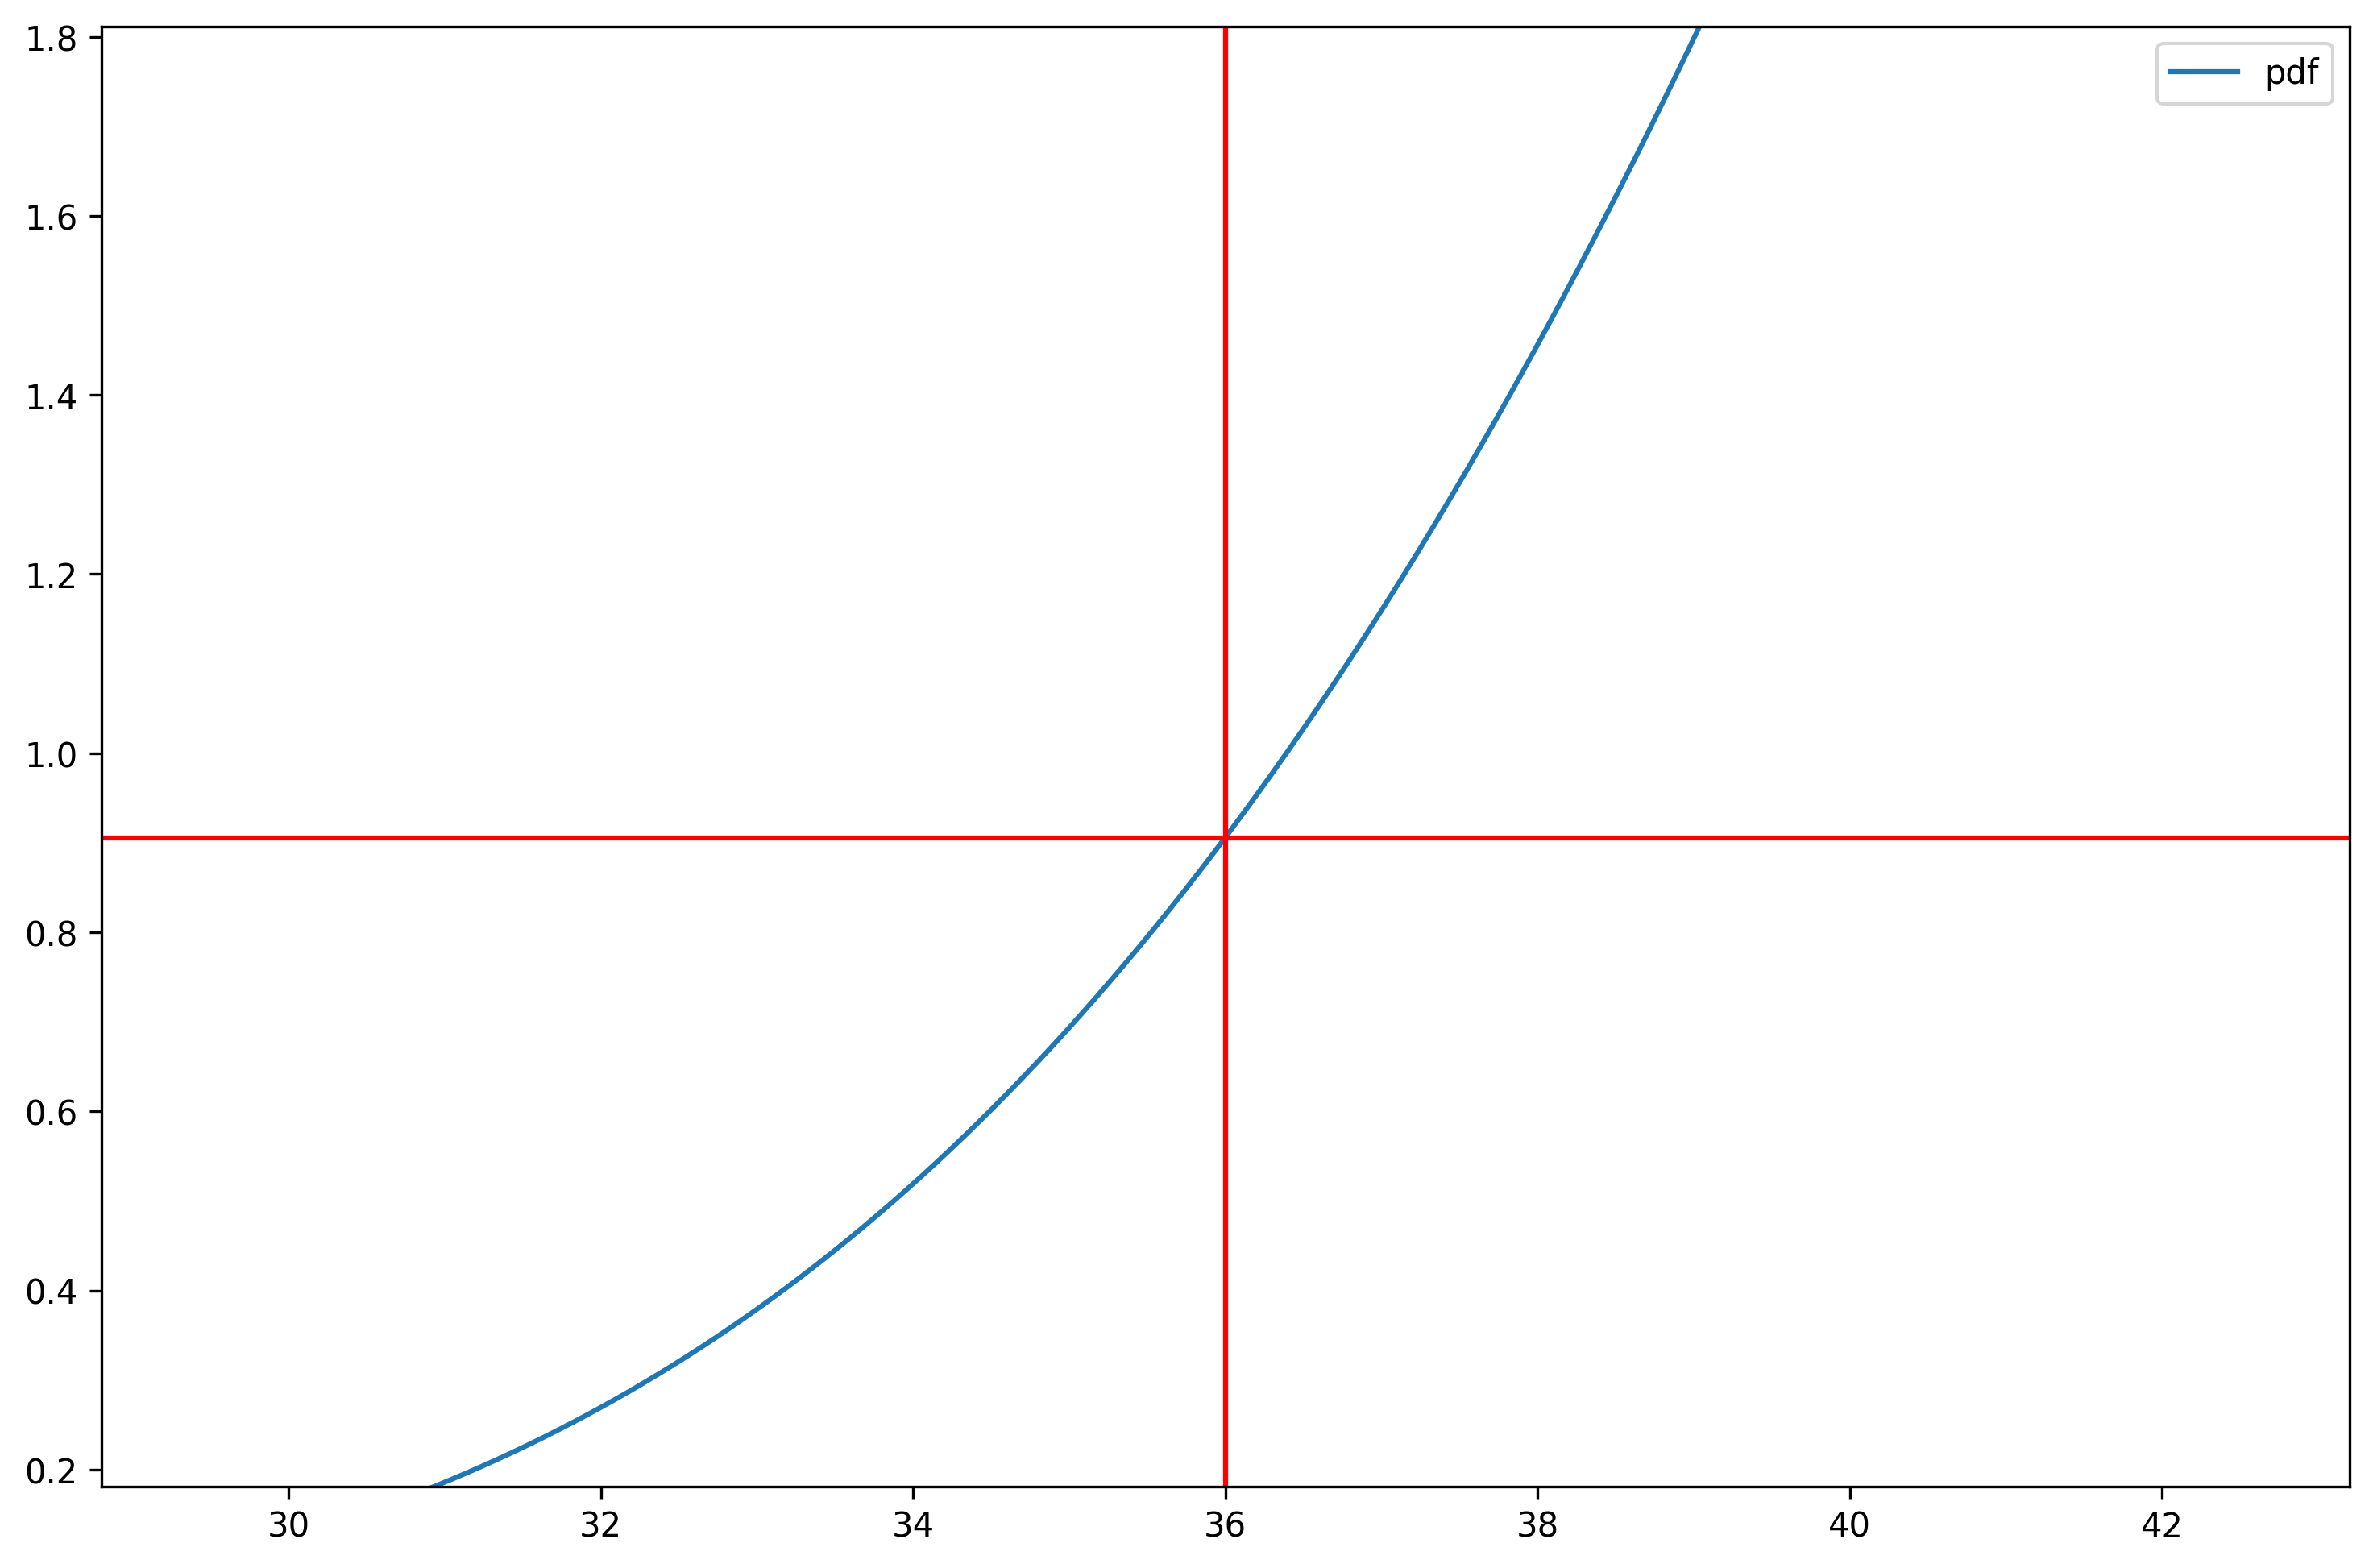

In [5]:
time_delta = 0.005
number_grid_points = 1024

estimate, grid_locations = american_option(
    time_delta=time_delta,
    expiry=tff.datetime.daycount_actual_actual_isda(
          start_date=tff.datetime.dates_from_tuples([(1998, 5, 15)]), 
          end_date=tff.datetime.dates_from_tuples([(1999, 5, 15)]),
          dtype=tf.float64).numpy()[0],
    number_grid_points=number_grid_points,
    volatility=tf.constant(0.20,tf.float64),
    risk_free_rate=tf.constant(0.02,tf.float64),
    dividend_rates=tf.constant(0.07,tf.float64),
    strike=tf.constant(40.0,tf.float64),
    spot=36.0,
    european_exercise=True,
    nb_bound=3.0,
    dtype=tf.float64)

# Convert to numpy for plotting
estimate = estimate.numpy()
grid_locations = grid_locations.numpy()
tqf_euro_price_pde = interp1d(grid_locations, estimate)(36.0)
print(estimate)
print(grid_locations)
print('premium', tqf_euro_price_pde)

plt.figure(dpi=300, figsize=(12.0, 8.0))
plt.plot(grid_locations, estimate, marker='', linestyle='-', label='pdf')
plt.legend()
plt.xlim(0.8*36.0, 1.2*36.0)
plt.ylim(0.2*tqf_euro_price_pde, 2.0*tqf_euro_price_pde)
plt.axvline(x=36.0, color='r')
plt.axhline(y=tqf_euro_price_pde, color='r')
plt.draw()

In [6]:
print(tqf_BS_price)
print(ql_price)
print(tqf_euro_price_pde)

0.9057414542975113
0.9057414542975114
0.9057680677666174


In [7]:
tqf_price_list = []
for nb_step in np.arange(50, 1024):
    tqf_price_list.append(tqf_price(time_delta=time_delta,
        expiry=tff.datetime.daycount_actual_actual_isda(
              start_date=tff.datetime.dates_from_tuples([(1998, 5, 15)]), 
              end_date=tff.datetime.dates_from_tuples([(1999, 5, 15)]),
              dtype=tf.float64).numpy()[0],
        number_grid_points=nb_step,
        volatility=tf.constant(0.20,tf.float64),
        risk_free_rate=tf.constant(0.02,tf.float64),
        dividend_rates=tf.constant(0.07,tf.float64),
        strike=tf.constant(40.0,tf.float64),
        spot=36.0,
        european_exercise=True,
        nb_bound=3.0,
        dtype=tf.float64))

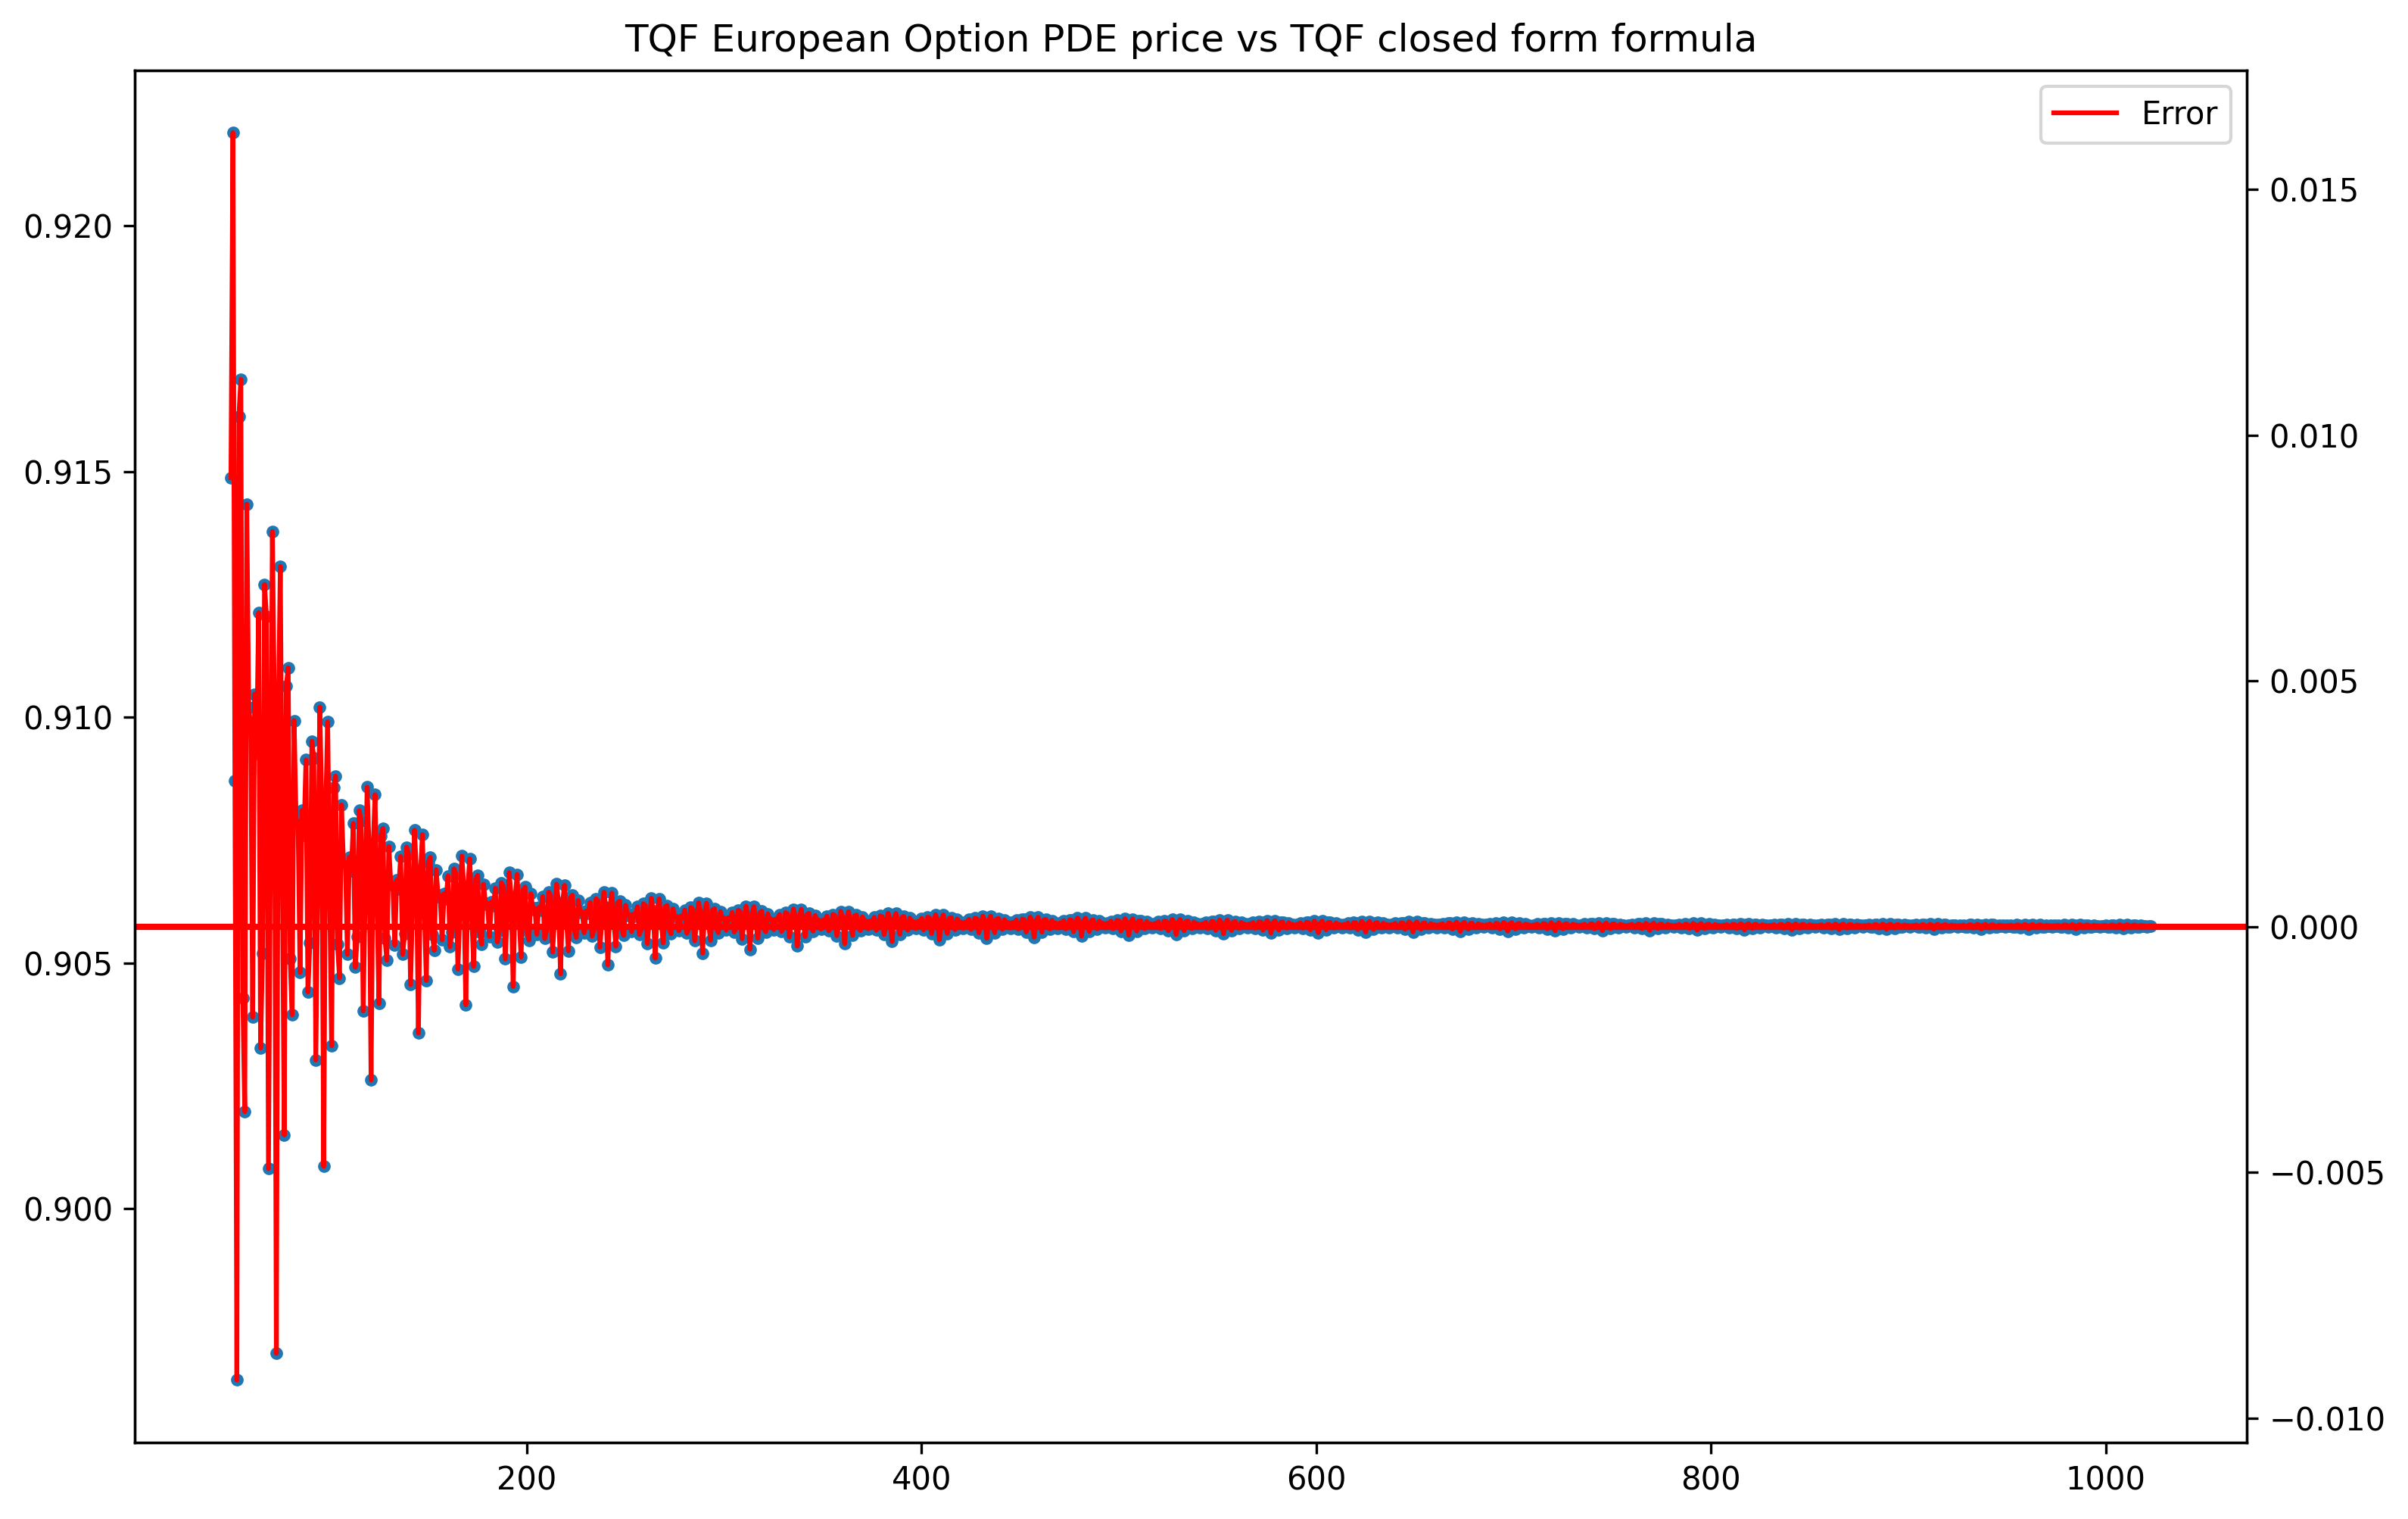

In [8]:
plt.figure(dpi=300, figsize=(12.0, 8.0))
plt.plot(np.arange(50, 1024), tqf_price_list, marker='.', linestyle='', label='TQF European PDE Price')
plt.axhline(y=tqf_BS_price, linewidth=2, color='r')
plt.twinx()
plt.plot(np.arange(50, 1024), tqf_price_list-tqf_BS_price, marker='', linestyle='-', label='Error', color='r')
plt.title("TQF European Option PDE price vs TQF closed form formula")
plt.legend()
plt.draw()